# Spotify Popularity Prediction
## PSTAT 131 Final Project
By Annie Huang, Ian Gascon, James Du, Meng Vong


## Background

With the competitiveness of the music industry, it has become essential for producers to create music that will be popular among the general audience in order to make a profit. In the age of big data, the secret to the next biggest hit may lie within the information gathered from the largest music streaming service in the world: Spotify, an online audio streaming and media service provider with over [406 million monthly active users.](https://www.musicbusinessworldwide.com/spotify-subscriptions-grew-to-180m-in-2021-monthly-active-users-topped-406m12/)

Using data from the [Spotify Web API](https://developer.spotify.com/documentation/web-api/), we modeled a song's popularity with Spotify's listeners in respect to the song's musical features in order to answer the question: which features relating to musical composition factor into
the popularity of a song on Spotify?


## Data Description

Our dataset from the [Spotify Web API](https://developer.spotify.com/documentation/web-api/) includes song names, their associated popularity scores, and characteristics of each song. According to Spotify’s API documentation, “popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past.”

There are 228159 unique observations and 15 potential predictors in this dataset. The predictors include song features such as:

1. ***Genre:*** A list of genres associated with the track.
2. ***Artist Name:*** The artist who performed the track.
3. ***Acousticness:*** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
4. ***Danceability:*** Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.
5. ***Duration_ms:*** The track length in milliseconds.
6. ***Energy:*** Measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
7. ***Instrumentalness:*** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal".
8. ***Key:*** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C$\sharp$/D$\flat$, 2 = D, and so on. If no key was detected, the value is -1.
9. ***Liveness:*** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
10. ***Loudness:*** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.
11. ***Mode:*** Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived.
12. ***Speechiness:*** Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0.
13. ***Tempo:*** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
14. ***Time Signature:*** The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
15. ***Valence:*** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

## Methods &amp; Results

The packages we used in the project are imported below. 

In [54]:
# importing relevant packages

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import math

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import altair as alt
import plotly.express as px
import plotly.graph_objects as go

from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate

import scipy.stats as sps

### Data Preprocessing

First, we load in our dataset from Kaggle.

In [55]:
songs_raw = pd.read_csv('../data/SpotifyFeatures.csv')

Coming directly from the Spotify API, the dataset is pretty clean. However, there is an issue in which some song tracks are listed twice under multiple genres. For example, Ariana Grande's '7 rings' is listed as both Pop and Dance.

In [56]:
songs_raw[songs_raw['track_name'] == '7 rings']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
12710,Pop,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.578,0.725,178640,0.321,0.0,C#,0.0884,-10.744,Minor,0.323,70.142,4/4,0.319
159005,Dance,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.578,0.725,178640,0.321,0.0,C#,0.0884,-10.744,Minor,0.323,70.142,4/4,0.319


Since we need only one listing of each song in our dataset, we opted to only keep the first occurrence of each track while dropping the duplicates. This was the simplest way, as many songs have overlap in categories and it would be difficult to pinpoint which exact category it belongs more to.

In [57]:
songs = songs_raw.drop_duplicates(subset='track_id', keep="first").reset_index(drop = True)

In [58]:
songs[songs['track_name'] == '7 rings']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
12261,Pop,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.578,0.725,178640,0.321,0.0,C#,0.0884,-10.744,Minor,0.323,70.142,4/4,0.319


While this solved our issue of duplicate tracks, we did need to keep in mind that when using genre as a factor or predictor later on in the project, our data could be skewed depending on which songs ending up in which of their potential genres. However, it shouldn't pose too much of a trouble since there is bound to be overlap in the related categories anyways.

### Exploratory Analysis

Now that we've cleaned our dataset, we can finally use it for our project!

Here we are grouping by genre so we can determine the average popularity wthin each genre. We've also sorted in ascending popularity to showcase which genres are the least popular in our dataframe table below, but also for the purpose of visualizing it in a sorted bar chart.

In [59]:
# group songs by genre and sort by popularity
songs1 = songs.groupby(['genre']).mean().reset_index().sort_values('popularity').iloc[:, 0:2]
songs1.head()

,genre,popularity
0,A Capella,9.302521
12,Movie,11.428723
13,Opera,12.705867
4,Comedy,21.329648
20,Ska,27.461855


In [60]:
fig = px.bar(songs1, y="genre", x='popularity', orientation='h', title='Spotify Average Popularity by Genre')
fig.show() #wow pop so popular

From our histogram, we see that the Pop genre is typically has the more popular songs on spotify, with A Capella being lesser popular. This makes sense and can be interpreted as how an original song is typically more popular than a cover by another singer. A Capellas are usually covers of other songs (in various genres), and thus explaining their lesser popularity.

Text(0.5, 1.0, 'Spotify Popularity Density Histogram')

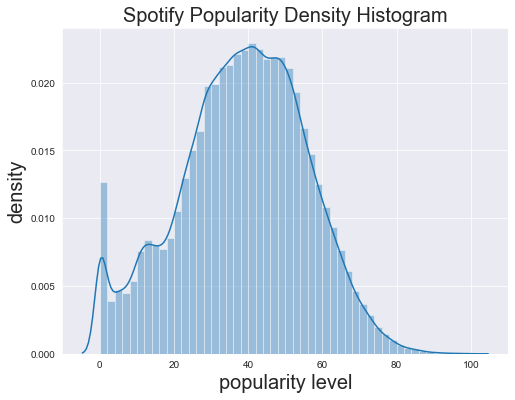

In [61]:
# change plot size
plt.figure(figsize=(8,6))

# distplot
p = sns.distplot(songs['popularity'])
p.set_xlabel('popularity level', fontsize = 20)
p.set_ylabel("density", fontsize = 20)
p.set_title('Spotify Popularity Density Histogram', fontsize = 20)

From our density histogram we can see that the distribution of songs by their popularity level is similar to that of a normal distribution. Most song's popularity level are in the middle at around 30-50. There are fewer songs that are on the higher and lower end of the popularity scale, with the only exception being songs with 0 popularity. This can be explained since the popularity score is based on spotify's API algorithm and one of its significant weights is the song's current popularity. Thus, older songs that just aren't being played as often anymore will have its popularity slowly be lower until it eventually drops to 0.


Here we are creating a dataframe called songs_count in order to count the amount of songs in each genre at each popularity point level

In [62]:
# count songs by popularity and genre
songs_count = songs.groupby(['genre','popularity']).count().reset_index()[['genre', 'popularity', 'energy']]
songs_count = songs_count.rename(columns={"energy": "count"})

Next we are creating a dataframe map to add the total amount of songs and the median in each genre. The total amount of songs is used to find the density while the median is used for sorting the boxplot.

In [63]:
# creating map of total songs and the median for each genre
genre_map = songs_count.groupby(['genre']).sum().reset_index()[['genre', 'count']]
median_col = songs_count.groupby(['genre']).median().reset_index()[['popularity']]
genre_map['median'] = median_col

Then we are going to merge the dataframes together and calculate the density by dividing the count by the total, and finilizing by sorting by the median count of songs for each genre.

In [64]:
# mergeing the count of songs dataframe with its total count and median map
songs_merge = songs_count.merge(genre_map, left_on='genre', right_on='genre')

# create a new column for density 
songs_merge['density'] = songs_merge['count_x'] / songs_merge['count_y']

# sorting by median
songs_merge = songs_merge.sort_values(by='median', ascending=True)

Using this dataframe, we are going to create a density histogram facetted by each genre as well as a boxplot to show the distribution of song's popularity within each genre.

In [65]:
dense = alt.Chart(songs_merge).mark_bar().encode(
    alt.X("popularity", bin=alt.Bin(maxbins=25)),
    y='density',
).properties(
    width=160,
    height=160).facet(
    facet='genre', columns = 4
).resolve_axis(
    x='independent',
    y='independent',
)

dense

alt.FacetChart(...)

In [66]:
bars = px.box(songs_merge, x="popularity", y="genre", color = 'genre', width=950, height=950)
bars.layout.update(showlegend=False)
bars

While the density histogram gives us an overarching shape of popularity (which is similar to that of a normal shape), when we facet by genre, we see that this shape is not consistant for all the genres. Genres like movies and classical has a large proportion of their songs with 0 popularity. A lot of the genres however do follow the holistic shape of popularity distribution of being similar to a normal distribution, with a right or left skew for certain individual genres. For example, we have a right skew for pop songs as most songs in this genre are generally above average popularity, but only a few songs can really break that barrier and become a top hit.

Text(0.5, 1.025, 'Correlation Matrix: Song Features and Popularity')

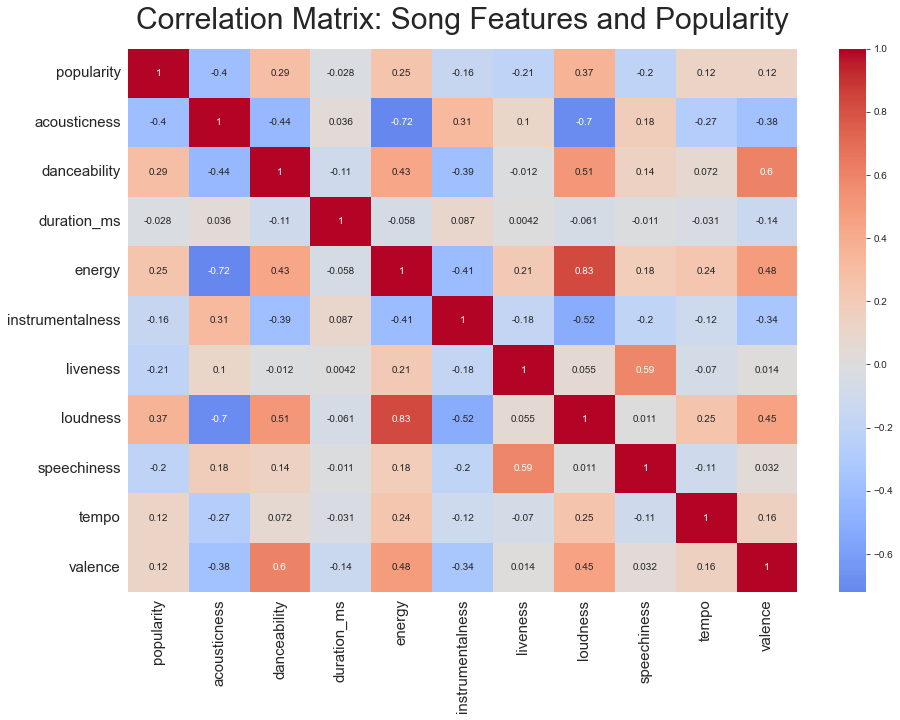

In [118]:
corrM = songs.corr()
div_col = sns.diverging_palette(10, 240, n=9, as_cmap = True)

fig_dims = (15, 10)

fig, ax1 = plt.subplots(figsize = fig_dims)
sns.heatmap(corrM, annot = True, cmap='coolwarm', ax = ax1, center = 0)
ax1.set_xticklabels(ax1.get_xmajorticklabels(), fontsize = 15, rotation = 90)
ax1.set_yticklabels(ax1.get_ymajorticklabels(), fontsize = 15, rotation = 0)
ax1.set_title('Correlation Matrix: Song Features and Popularity', fontsize=30, y = 1.025)

To get a better sense of how the song features reported in our dataset are correlated with each other, we visualized each of those interactions as a correlation matrix above. Since a correlation matrix displays the interactions between each of the features in our dataset, this is also a good method of visualizing any linear relationships that might exist between the features we have.

It is important to understand how to read a correlation matrix so that we can be confident in the insight we take away from it. The values in a correlation matrix can be between $-1$ and $1$ (inclusive).

| Correlation Value      | Interpretation |
| :---: | :---: |
| -1                     | There exists a perfectly negative linear correlation between the two features **(ex: as feature A increases, so does feature B)**       |
| 0                      | There exists no linear correlation between the two features **(ex: an increase feature A does not affect feature B)**        |
| 1                      | There exists a perfectly positive linear correlation between the two features **(ex: as feature A increases, feature B decreases)**        |

From this, we can see that the further a correlation value is from $0$, the more the two features you are looking at are related to each other.

Within every correlation matrix, you'll notice that there is a diagonal of correlation values equal to $1$. This is entirely normal since each feature is expected to be perfectly positively correlated with itself. With this, we have essentially confirmed that as we eat more cookies, the number of cookies we eat increases! This diagonal does not give us insight into the relationship between the features in our data.

For a useful takeaway from  this correlation matrix (remembering that we are interested in the correlation between song features and popularity) we can see that there really are no strong correlations between the features of a song and a song's popularity. This suggests that it would be difficult to try to predict a song's popularity based on the song's features since the song's features tell us little about it's popularity.

There is ***technically*** still some good news from this correlation matrix. The matrix suggests that our data does not exhibit multicollinearity since there do not exist a high amount of correlations; implying that we may be able to find a reliable regression model!

For example, when looking at the variable of interest popularity, we see that not a lot of other variables are correlated with it which is unfortunate for our plans. It looks like nothing the universe will go right for us.

Ignoring that though, we see a lot of other patterns that make sense such as the correlation between energy and loudness is very strong and positive at .81 It's like that one loud guy at the party who's always energetic and drunk as heck. On the other hand, these two variables have a very strong negative correlation against acoustic levels. This can be explained by how songs with lower acoustic levels are generally more electronic and meant for EDM and parties. This versus music with higher acoustic composition includes typically only instrumental sounds which is generally less loud and softer than what electronic music can accomplish. 

Now we want to look at a correlation heatmap within each individual genres. Thus we will be creating a dataframe of each variable that have a numerical value and find it's correlation coefficient against each of the other variable. The difference here is that this is done for each individual genre.

In [71]:
# correlation by genre
corrs = songs.groupby(['genre']).corr().reset_index()
corrs = pd.melt(corrs, id_vars=['genre', 'level_1'], var_name = 'col', value_name = 'Correlation').rename({'level_1':'row'}, axis=1)
corrs['order'] = (corrs['row'] != 'popularity').astype(int)

Next we will be creating our correlation heatmap facetted by genres. We have sorted and put the popularity variable in the beginning so it is easier to compare that variable against all the other variables due to it being our variable of interest.

In [72]:
alt.Chart(corrs).mark_rect().encode(
    x= alt.X('row', sort=alt.EncodingSortField(field='order', order='ascending')),
    y= alt.Y('col', sort=alt.EncodingSortField(field='order', order='ascending')),
    color = alt.Color('Correlation', 
                      scale = alt.Scale(scheme = 'blueorange'))
).properties(
    width=170,
    height=170
).facet(
    facet='genre', columns = 3
).resolve_axis(
    x='independent',
    y='independent',
)


alt.FacetChart(...)

Songs of different genres would have a different composition in how the music is constructed and made. Thus, it would make sense to facet the correlation matrix by genres to see whether these variables are correlated differently depending on the genres. We are most interested in seeing if any variable is correlated to popularity, and even after faceting by genres, no singular variable seems to be associated with it. Thus, we are hypothesizing that our linear regression model would have a lot of error.

### Multiple Linear Regression

Because the target variable we were interested in predicting was the quantitative 'popularity' variable, we began our approach by attempting a multiple linear regression model. To begin with, we made sure that all the categorical predictors could be treated as category.

In [73]:
songs.columns.to_series().groupby(songs.dtypes).groups

{int64: ['popularity', 'duration_ms'], float64: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'], object: ['genre', 'artist_name', 'track_name', 'track_id', 'key', 'mode', 'time_signature']}

As we can see, the columns 'genre', 'artist_name', 'track_name', 'track_id', 'key', 'mode', 'time_signature' are categorical. Thus, we cast them as numerical categories and save the respective keys for reference later.

In [74]:
## Extract to-be-hashed values for reference later

unhashed = pd.DataFrame({'genre': songs['genre'],
                         'artist_name': songs['artist_name'],
                         'key': songs['key'],
                         'mode': songs['mode'],
                         'time_signature': songs['time_signature']}) ## Add other categorical values here if need to be hashed

## Any Categorical Data Can be converted, just enter it under this section (Automize if you wish)
songs['genre'] = songs['genre'].astype('category')
songs['artist_name'] = songs['artist_name'].astype('category')
songs['key'] = songs['key'].astype('category')
songs['mode'] = songs['mode'].astype('category')
songs['time_signature'] = songs['time_signature'].astype('category')

cat_columns = songs.select_dtypes(['category']).columns

songs[cat_columns] = songs[cat_columns].apply(lambda x: x.cat.codes)

print(songs[cat_columns].head()) # Altered Columns
print(unhashed.head()) #Original Columns

   genre  artist_name  key  mode  time_signature
0     13         4398    4     0               3
1     13         4343    6     0               3
2     13         4343    3     0               2
3     13         4398    5     0               3
4     13         4398    5     0               3
   genre      artist_name key   mode time_signature
0  Opera   Giuseppe Verdi  C#  Major            4/4
1  Opera  Giacomo Puccini  D#  Major            4/4
2  Opera  Giacomo Puccini   C  Major            3/4
3  Opera   Giuseppe Verdi   D  Major            4/4
4  Opera   Giuseppe Verdi   D  Major            4/4


Because we want to provide our popularity prediction model with information on all the musical features of the songs, we want to use all potential predictors.

In [75]:
predictors = ['acousticness', 'danceability', 'duration_ms', 'energy',
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
              'speechiness', 'tempo', 'time_signature', 'valence']

Then, we split our datasets columns between the columns for song feature predictors and the column for popularity, the truth values.

In [76]:
x = songs[predictors]

y = songs['popularity']

Next, we split the data with 80% for training the model and 20% for testing. 

In [77]:
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 131)

Now, we can create the multiple linear regression model using the LinearRegression package from scikit-learn.

In [78]:
LR = linear_model.LinearRegression()
LR.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

If we test our new model on the data we trained it with, we get the following results:

In [79]:
y_prediction_train = LR.predict(x_train)
y_prediction_train

array([19.74014291, 27.29746322, 35.20446637, ..., 40.84928674,
       45.6604543 , 35.3011991 ])

In [80]:
score_tr=r2_score(y_train,y_prediction_train)

print('R2 Score:',score_tr)
print('MSE',mean_squared_error(y_train,y_prediction_train))
print('RMSE',np.sqrt(mean_squared_error(y_train,y_prediction_train)))

R2 Score: 0.2478093221653337
MSE 219.93298360525154
RMSE 14.83013767991557


As we can see, the R^2 of this model on its own training data is quite low at 0.2478093221653337. This suggest that there is no or very little proportion of the variance for popularity that is explained by the features present in our dataset.

This is quite concerning, as if there was a clear linear correlation between the popularity score and its song feature predictors detected by the model, it would be expected to have a higher R^2 score, especially because it's tested on its own training data. If we look at the model predictions on the test set...

In [81]:
y_prediction =  LR.predict(x_test)
y_prediction

array([49.32253191, 28.48024439, 32.41642049, ..., 43.32229663,
       47.18795201, 38.66244374])

In [82]:
score=r2_score(y_test,y_prediction)

print('R2 Score:',score)
print('MSE',mean_squared_error(y_test,y_prediction))
print('RMSE',np.sqrt(mean_squared_error(y_test,y_prediction)))

R2 Score: 0.2542533160236401
MSE 219.75412970119612
RMSE 14.824106371083422


We see that the R^2 of this model on the testing data is at 0.25425331602397294. While it is slightly higher than the training R^2,this still suggests that there is no or very little proportion of the variance for popularity that is explained by the features present in our dataset. At the very least, we can see that this model is not overfit, as the training accuracy and the testing accuracy are quite similar.

In [83]:
MLR_scores_df = pd.DataFrame()
MLR_scores_df = MLR_scores_df.append({'Data': 'train', 
                                      'R2': score_tr, 
                 'MSE': mean_squared_error(y_train,y_prediction_train), 
                 'RMSE': np.sqrt(mean_squared_error(y_train,y_prediction_train))}, ignore_index = True)
MLR_scores_df = MLR_scores_df.append({'Data': 'test',
                                      'R2': score, 
                                      'MSE': mean_squared_error(y_test,y_prediction), 
                                      'RMSE': np.sqrt(mean_squared_error(y_test,y_prediction))}, ignore_index = True)
MLR_scores_df.set_index('Data')

,R2,MSE,RMSE
Data,,,
train,0.247809,219.932984,14.830138
test,0.254253,219.754130,14.824106


It's possible that each genre has it's own combination of features that make a song popular — that is, it's possible that creating a model with song features from every genre creates too much variance and noise. Therefore, we decided to create a multiple linear regression model for each individual genre.

To do this, we have a function to create an multiple linear regression model on a specific genre and run it over all the genres available in the dataset. 

In [84]:
def genre_MLR_score(genre, songs, unhashed, predictors):
    
    genre_indices = unhashed[unhashed['genre'] == genre].index.values.tolist()
    genre_songs = songs.iloc[genre_indices]
    
    x = genre_songs[predictors] 
    y = genre_songs['popularity']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 131)
    
    LR = linear_model.LinearRegression()
    LR.fit(x_train, y_train)
    
    y_prediction_train = LR.predict(x_train)
    y_prediction =  LR.predict(x_test)
    
    score_train = r2_score(y_train,y_prediction_train)
    
    score=r2_score(y_test,y_prediction)
    
    genre_df = {'Genre': genre, 'Count': len(genre_songs),
                'R2_train': score_train, 'MSE_train': mean_squared_error(y_train,y_prediction_train), 'RMSE_train': np.sqrt(mean_squared_error(y_train,y_prediction_train)),
                'R2': score, 'MSE': mean_squared_error(y_test,y_prediction), 'RMSE': np.sqrt(mean_squared_error(y_test,y_prediction))}
    
    return genre_df

In [85]:
genres = list(unhashed.genre.unique())
genre_scores_df = pd.DataFrame()

for genre in genres:
    genre_df = genre_MLR_score(genre, songs, unhashed, predictors)
    genre_scores_df = genre_scores_df.append(genre_df, ignore_index = True)

With this, we can see the results of our model. For example, the figure below shows the R^2 scores for each model:

In [86]:
genre_scores_df.sort_values(by = 'R2', ascending = False).head()

,Genre,Count,R2_train,MSE_train,RMSE_train,R2,MSE,RMSE
12,Hip-Hop,2285.0,0.112281,49.433244,7.030878,0.132791,38.623886,6.214812
10,Classical,9250.0,0.137986,172.009988,13.115258,0.127709,172.839843,13.146857
13,Comedy,9677.0,0.075623,64.658680,8.041062,0.071753,68.159221,8.255860
15,Reggaeton,8537.0,0.066926,140.096140,11.836222,0.068689,134.615680,11.602400
23,Movie,7555.0,0.059795,158.966571,12.608195,0.063064,165.746325,12.874250


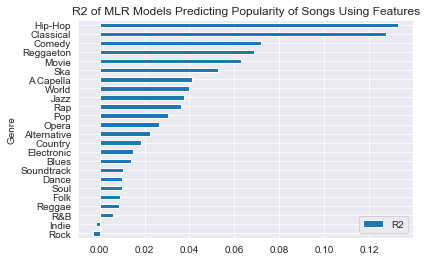

In [87]:
genre_scores_df_R2 = genre_scores_df.sort_values(by = 'R2', ascending = True)
ax = genre_scores_df_R2.plot.barh(x='Genre', y='R2', rot=0, title = 'R2 of MLR Models Predicting Popularity of Songs Using Features')

As we can see, the genres Hip-Hop and Classical seem to have the highest R^2 scores, although they are still quite low around 0.12. With genres such as rock where there may be a higher variance in the features in a popular song, there is a R^2 closer to 0, indicating that there is likely no proportion of the variance in popularity score explained by our song features. In fact, the negative R2 values of Indie and Rock may indicate that the model can be arbitrarily worse linearly.

Next, we sort by Root Mean Square Error to see which models have the lowest amount of error.

In [88]:
genre_scores_df.sort_values(by = 'RMSE', ascending = True).head()

,Genre,Count,R2_train,MSE_train,RMSE_train,R2,MSE,RMSE
3,Blues,3295.0,0.015041,40.033232,6.327182,0.013841,37.253784,6.103588
12,Hip-Hop,2285.0,0.112281,49.433244,7.030878,0.132791,38.623886,6.214812
1,A Capella,119.0,0.269926,47.339221,6.880350,0.041086,45.466842,6.742911
17,Indie,2783.0,0.051729,44.768716,6.690943,-0.001511,46.482416,6.817801
7,R&B,4870.0,0.013289,43.932592,6.628167,0.005954,50.677112,7.118786


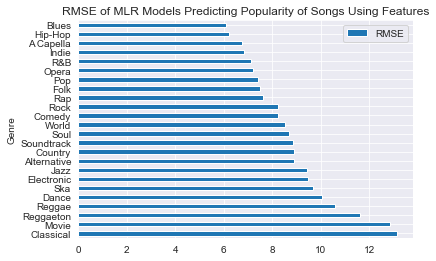

In [89]:
genre_scores_df_RMSE = genre_scores_df.sort_values(by = 'RMSE', ascending = False)
ax = genre_scores_df_RMSE.plot.barh(x='Genre', y='RMSE', rot=0, title = 'RMSE of MLR Models Predicting Popularity of Songs Using Features')

We can see from this plot that the genres with lowest RMSE are Blues, Hip-Hop, A Capella, and so on. This means that their models consistently predicted within 8 points of their true score, which is not too bad. Interestingly, these are some of the genres with density plots in popularity with most of the density centered at the middle around 50 popularity. This may attribute to the lower RMSE. The opposite is also true, as genres with high densities focused around the lower end of the plot had higher RMSE, such as with Classical or Movie. 

### Principal Component Analysis (PCA)

In order to fit our data into a PCA model for dimension reduction, we first need to remove our target variable popularity, and then remove all non-numerical columns within our dataset.

In [90]:
# define which predictor variables are numerical
numerical = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
              'speechiness', 'tempo', 'valence']

# select only numerical data
songs_numerical = songs[numerical]

Next we scaled our data to have a mean of 0 and a standard deviation of 1 to make sure that each predictor variable holds the same weight if they are measured in different units. 

In [91]:
# center and scale data
songs_ctr = (songs_numerical - songs_numerical.mean())/songs_numerical.std()

Then we defined our PCA model and fit our scaled data.

In [92]:
# PCA fitting 
pca = PCA(n_components = songs_ctr.shape[1]) 
pca.fit(songs_ctr)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Lastly, we created a dataframe to visualize our principal component variation. Thus we have a column for each prinicipal component (we have 10 since we have 10 predictors), a column for the proportion of variartion explained by that principal component, and lastly a column for the cumulative proportion of variance explained.

In [93]:
# store proportion of variance explained as a dataframe
pca_var_explained = pd.DataFrame({'Proportion of variance explained': pca.explained_variance_ratio_})

# add component number as a new column
pca_var_explained['Component'] = np.arange(1, 11)

# add cumulative variance explained as a new column
pca_var_explained['Cumulative variance explained'] = pca_var_explained.iloc[:, 0].cumsum(axis = 0)

# reordering columns
pca_var_explained = pca_var_explained[['Component', 'Proportion of variance explained', 'Cumulative variance explained']]

# print
pca_var_explained.head()

,Component,Proportion of variance explained,Cumulative variance explained
0,1,0.366477,0.366477
1,2,0.173992,0.540469
2,3,0.106308,0.646777
3,4,0.093662,0.740439
4,5,0.075999,0.816438


From our results, we see that we need at least 5 principal components to explain around 80% of the variation in our data.Thus, let's only focus on visualizing the first 5 principal component.

Here we are constructing a dataframe to showcase the first five principal components against each predictor variable to see what weight each variable has.

In [94]:
# store the pca variation as a data frame with appropriate names
PCA_df = pd.DataFrame(pca.components_).transpose().rename(
    columns = {0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4', 4: 'PC5'} # add entries for each selected component
).loc[:, ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] # slice just components of interest

# add a column with the variable names
PCA_df['Variable'] = songs_numerical.columns.values

PCA_df

,PC1,PC2,PC3,PC4,PC5,Variable
0,0.406951,0.247598,-0.190143,-0.014101,0.327060,acousticness
1,-0.369851,0.014786,-0.324629,0.324669,0.323884,danceability
2,0.072330,-0.004129,0.737252,0.586755,0.321876,duration_ms
3,-0.455539,0.064463,0.213262,-0.059186,-0.281278,energy
4,0.327114,-0.182810,0.066059,-0.019773,-0.071946,instrumentalness
5,-0.061303,0.637898,0.180533,-0.179891,-0.079596,liveness
6,-0.462699,-0.057874,0.148974,0.006397,-0.247264,loudness
7,-0.060873,0.664109,0.015008,-0.047589,0.141837,speechiness
8,-0.166620,-0.220869,0.327400,-0.692923,0.564892,tempo
9,-0.358516,-0.028240,-0.320743,0.177220,0.439928,valence


We can visualize this dataframe as:

In [95]:
# melt from wide to long
PCA_plot_df = PCA_df.melt(
    id_vars = 'Variable',
    var_name = 'Principal Component',
    value_name = 'Loading'
)

# add a column of zeros to encode for x = 0 line to plot
PCA_plot_df['zero'] = np.repeat(0, len(PCA_plot_df))

# # create base layer
base = alt.Chart(PCA_plot_df)

# create lines + points for loadings
loadings = base.mark_line(point = True).encode(
    y = alt.X('Variable', title = ''),
    x = 'Loading',
    color = 'Principal Component'
)

# create line at zero
rule = base.mark_rule().encode(x = alt.X('zero', title = 'Value'), size = alt.value(0.05))

# layer
PCA_plot = (loadings + rule).properties(width = 120)

# show
PCA_plot.facet(column = alt.Column('Principal Component', title = ''))

alt.FacetChart(...)

We lose a lot of interpretability due to principal component analysis, but we can infer what the first two principal components might represent.

#### PC1
Positives: acousticness, instrumentalness

Negatives: dancebility, energy, koudness, valence

Interpretation: PC1 seems to be kinda depressing with the valance and energy being pretty negative. The lack of loudness and energy makes us assume that in addition to being kinda depressing, we are in some sort of emo phase of not wanting to be heard or seen and the only thing that can be represented in the song is the musical instruments. 

However, in a more serious interpretation, a lot of songs are constructed by the songwriter's emotions. And a lot more songs are about hardship and pain to try and connect with listeners and relate with whatever issue they may have. Thus, it makes sense for a lot of songs to be more sad and have the first principal component represent that.

#### PC2
Positives: liveness, speechiness

Negatives (weaker values): instrumentalness, tempo

Interpretation: PC2 seems to be more of the opposite of PC1 where things are very extroverted with a lot of spoken language and the song being more in a live setting then a studio setting. Most songs are written on some sort of strong emotion, and if there exists sad songs, there also exists more lighthearted and happier songs. Thus, PC2 may represent the construction of songs with a happier meaning and its song composition is constructed in tune with that idea.

### PCA Regression

We want to perform some sort of PCA Regression and thus, we first need to split our numerical predictor variables and store them into X and store our response variable popularity as y.

In [96]:
# split dataset into X and y for PCA
X = songs_numerical.copy()
y = songs[['popularity']]

Then we construct our PCA model and fit it using our scaled X data.

In [97]:
# fit a scaled PCA model 
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

Here we are defining our cross validation method as using 10 folds and repeating it 3 times to evaluate the performance of our PCA regression model. We chose a repeat of 3 to ensure a balance of both model accuracy but also minimize run time.

In [98]:
# define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=131)

Next we define a linear regression model to test our pca model on.

In [99]:
# create linear regression model for PCA and to compute MSE
PCA_lr = LinearRegression()

In order to evaluate our model's performance, we've create an empty list to append each models' mean squared error after each cross validation. Then we store that mse into our list.

In [100]:
# list to store PCA mse
PCA_mse = []

# Calculate MSE for each CV model
score = -1*model_selection.cross_val_score(PCA_lr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()

PCA_mse.append(score)

Lastly, we've implimented a for loop to check the cross validation MSE for each individual principal component.

In [101]:
# for loop to check cross validation MSE
for i in np.arange(1, 11):
    score = -1*model_selection.cross_val_score(PCA_lr,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    PCA_mse.append(score)

In order to visualize the performance of our model, we've created a dataframe of each principal component and the corresponding mse after using that many components for that model.

In [102]:
# converting PCA_mse into dataframe for plottng
PCA_mse_df = pd.DataFrame({'PCA': [i for i in np.arange(0,11)],
                     'mse': PCA_mse})

Our plot is as follows:

In [103]:
# plotly code
fig = px.line(PCA_mse_df, x='PCA', y='mse', markers=True, title = 'PCA mse')
fig.show()

From our visualization we see that our MSE decreases significantly after by adding in two principal components. Adding any more does lower our MSE very slightly but at the cost of adding dimensionality, defeating the purpose of PCA. However, there may be an argument to use eight principal components since it has one of the lowest mse.
Thus, the optimal model includes the usage of two principal components if we want to minimize mse and dimensionality, but we can also experiment with using eight principal components as well.

Before starting our PCA regression, we first split our dataset into 80% training and 20% testing with a random state of 131 for PSTAT 131 for consistancy.

In [104]:
# split the dataset into training (80%) and testing (20%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=131) 

Then, we are going to reduce the dimensionality of our X training and testing set to only include the first 2 principal components.

In [105]:
# use first 2 PC
X_red_train = pca.fit_transform(scale(X_train))
X_red_test = pca.transform(scale(X_test))[:,:3]

Next we are defining a linear regression model and fit our PCA dataframe.

In [106]:
# train PCR model on training data 
pca_lr = LinearRegression()
pca_lr.fit(X_red_train[:,:3], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now that our model is fit, we are going to use it to predict popularity via the training and testing set to produce a root mean squared error for each. We are evaulating for both training and testing to see for any signs of overfitting.

In [107]:
# calculate RMSE for training
pred_train = pca_lr.predict(pca.transform(scale(X_train))[:,:3])
train_mse = np.sqrt(mean_squared_error(y_train, pred_train))

# calculate RMSE for testing
pred_test = pca_lr.predict(X_red_test)
test_mse = np.sqrt(mean_squared_error(y_test, pred_test))

# RMSE printed
print('Our train rmse:', train_mse, ' Our test rmse:', test_mse)

Our train rmse: 15.375613987323485  Our test rmse: 15.375743540897739


We can see that both our train and test rmse are very close to each other at around ~15.376. This is the average deviation between the predicted value for average popularity in comparison to the true observed values. While PCA regression is good in reducing our dimension, we see that it also resulted in higher error in comparison to our linear regression model. 

We can use eight prinicpal components to see if it makes a difference.

In [108]:
# split the dataset into training (80%) and testing (20%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=131) 

# use first 2 PC
X_red_train = pca.fit_transform(scale(X_train))
X_red_test = pca.transform(scale(X_test))[:,:9]

# train PCR model on training data 
pca_lr = LinearRegression()
pca_lr.fit(X_red_train[:,:9], y_train)

# calculate RMSE for training
pred_train = pca_lr.predict(pca.transform(scale(X_train))[:,:9])
train_mse = np.sqrt(mean_squared_error(y_train, pred_train))

# calculate RMSE for testing
pred_test = pca_lr.predict(X_red_test)
test_mse = np.sqrt(mean_squared_error(y_test, pred_test))

print('Our train rmse:', train_mse, ' Our test rmse:', test_mse)

Our train rmse: 14.87432978436434  Our test rmse: 14.87527821730186


Our training and testing rmse actually improved to be around ~14.874 for our training set and ~14.875 for our testing set. However, this is still less than our linear model which had around an rmse of ~14.83 for training and ~14.82 for testing. Thus, if we want to preserve interpretability, it may be best to use the multiple linear regression model since it is both more interpretable and has less error. However, one good thing about our PCA regression models is that it can lower dimensionality and that we know our model is not overfit due to the training and testing rmse being almost identical.

### Decision Trees and Random Forest


![Decision Trees](https://media.wired.com/photos/5932a1bb4dc9b45ccec5f579/master/pass/xkcd_click_and_drag_2.jpg)

<figcaption>

*Panel taken from xkcd [Click and Drag](https://xkcd.com/1110/) showing how deep trees can get.*

</figcaption>

**Decision Tree:** a type of Supervised Learning Method where data is split on decision nodes according to specific paramters/patterns in the data. After the tree splits the data into the final classifications, we arrive at the tree's results (analagous to leaves).

**Random Forest:** an ensemble learning method for classification or regression that utilizes a "forest" of decision trees simultaneously while training. Since we are sticking to classification, the nodes and results of our forest is created from a "majority wins" vote on the results of the individual trees in the forest.

As we began thinking about the construction of a Decision Tree and Random Forest Model, we wanted to understand the data we were feeding the model.

In [109]:
songs = pd.read_csv('../data/SpotifyCleaned.csv')
songs.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Opera,Giuseppe Verdi,"Stiffelio, Act III: Ei fugge! … Lina, pensai c...",7EsKYeHtTc4H4xWiTqSVZA,21,0.986,0.313,490867,0.23100,0.000431,C#,0.0964,-14.287,Major,0.0547,86.001,4/4,0.0886
1,Opera,Giacomo Puccini,Madama Butterfly / Act 1: ... E soffitto e pareti,7MfmRBvqaW0I6UTxXnad8p,18,0.972,0.360,176797,0.20100,0.028000,D#,0.1330,-19.794,Major,0.0581,131.798,4/4,0.3690
2,Opera,Giacomo Puccini,"Turandot / Act 2: Gloria, gloria, o vincitore",7pBo1GDhIysyUMFXiDVoON,10,0.935,0.168,266184,0.47000,0.020400,C,0.3630,-8.415,Major,0.0383,75.126,3/4,0.0696
3,Opera,Giuseppe Verdi,"Rigoletto, Act IV: Venti scudi hai tu detto?",02mvYZX5aKNzdqEo6jF20m,17,0.961,0.250,288573,0.00605,0.000000,D,0.1200,-33.440,Major,0.0480,76.493,4/4,0.0380
4,Opera,Giuseppe Verdi,"Don Carlo / Act 4: ""Ella giammai m'amò!""",03TW0jwGMGhUabAjOpB1T9,19,0.985,0.142,629760,0.05800,0.146000,D,0.0969,-23.625,Major,0.0493,172.935,4/4,0.0382


Here we are using the same cleaned data we created before. With this, we have to keep a few considerations in mind:

1. Decision trees are great at classifying so we have to create categories that our model can identify (Popular/Not Popular)
2. We have a number of categorical features that are currently strings within our data.

Tackling these points one at a time, we can create a classifications for our model to predict. Since our variable of interest is **popularity**, we can create a tag for each song to label them Popular or Not Popular. Taking another look at the distribution of popular songs in our data set:

Text(0.5, 1.0, 'Spotify Popularity Density Histogram')

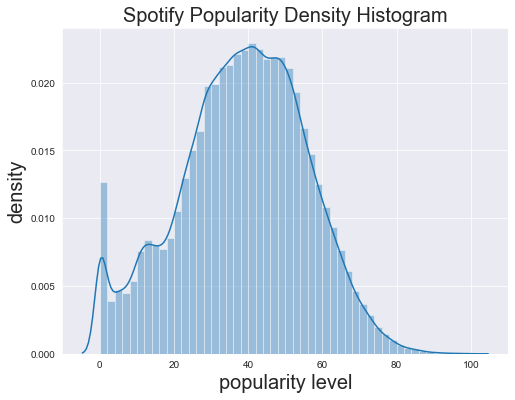

In [110]:
# change plot size
plt.figure(figsize=(8,6))

# distplot
p = sns.distplot(songs['popularity'])
p.set_xlabel('popularity level', fontsize = 20)
p.set_ylabel("density", fontsize = 20)
p.set_title('Spotify Popularity Density Histogram', fontsize = 20)

We can see that the mean of this distribution is around a popularity level of 40. Assuming that popular songs are more well known than the "average song," we will create a popularity threshold that identifies songs with a popularity level greater than 60 as *Popular* and songs below a popularity level of 60 as *Not Popular*.

***(Note: This is an over-simplification of how songs could be considered popular but for the sake of this model, that is the definition we will stick with.)***

In [111]:
songs_class = songs.copy(deep = True)
songs_class['is_popular'] = 0

## Tunable Hyperparameter
popularity_threshold = 60

songs_class.loc[songs_class.popularity > popularity_threshold, "is_popular"] = 1

Tackling the second point (categorical features are currently strings within our dataset) we can use label encoding to convert each string within our data to categories that are represented as integers and are more widely "machine-readable."

In [112]:
category_columns = ['genre', 'artist_name', 'track_name', 'key', 'mode', 'time_signature']

for label in category_columns:
    songs_class[label] = LabelEncoder().fit(songs_class[label]).transform(songs_class[label])

Now that we have created labels for our decision tree to predict and encoded our categorical features to be their own labels, we can start creating the Decision Tree model. The first step in any setup is to create a Train/Test Split from our data. Both ouur training set and our testing set will have a dataframe of features (X) and the array of ground truth values we are attempting to predict (y). In this case, X contains each song's features and y contains the labels we created above identifying each song as Popular or Not Popular.

In [113]:
features = ['genre', 'artist_name', 'track_name',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']

X = songs_class[features]

y = songs_class.is_popular

Now that we have our sets X and y, we can actually create the Train/Test split by using the built in sklearn method. We will be creating a training set that contains $80%$ of the data in our set and a testing set that contains $20%$ of the data in our set.

In [114]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=131) # 80% training and 20% test

In [115]:
#Tunable Hyperparameters
n_estimators = [25, 30, 35, 40, 45] # 100 Default
max_depth = [15, 20, 25, 30] # None for unlimited (default) #n_features = 16 
# Bootstrapping = True found to consistently slightly increase prediction probability

We created the below loop to tune our hyperparameters:

```python
for i in n_estimators:
    for j in max_depth:          
        # Create Decision Tree classifer object
        clf = RandomForestClassifier(n_estimators = i, max_depth = j,
                         criterion="entropy", random_state = 131)

        # Train Decision Tree Classifer
        clf = clf.fit(X_train,y_train)

        #Predict the response for test dataset
        y_pred = clf.predict(X_test)

        print("n_estimators = ", i , ', max_depth = ', j , ', Accuracy: ', metrics.accuracy_score(y_test, y_pred))
```

From this, we found that the Strongest Predictor had:

* Best Number of Estimators: 35

* Best Maximum Depth: 20

* Accuracy: 93.33%

From this, we were also able to see that bootstraping consistently out performed our non-bootstrapping decision tree models.

In [ ]:
# The Regressor requires different Labels

yi_test = pd.DataFrame(y_test)
yr_test = yi_test.join(songs_class['popularity']).iloc[:, 1]

yi_train = pd.DataFrame(y_train)
yr_train = yi_train.join(songs_class['popularity']).iloc[:, 1]

In [ ]:
#Tunable Hyperparameters
n_estimators1 = [150, 250, 350] # 100 Default
max_depth1 = [15, 20, 25] # None for unlimited (default) #n_features = 16 
# Bootstrapping = True found to consistently slightly increase prediction probability

After the success of our Random Forest, we wanted to see how a Random Forest Regressor model would perform.

```python
for i in n_estimators1:
    for j in max_depth1:          
        # Create Decision Tree classifer object
        reg = RandomForestRegressor(n_estimators = i, max_depth = j, random_state = 131)

        # Train Decision Tree Classifer
        reg = reg.fit(X_train,yr_train)

        #Predict the response for test dataset
        #y_pred = reg.predict(X_test)

        print("n_estimators = ", i , ', max_depth = ', j , ', Accuracy: ', reg.score(X_test, yr_test))
```

From this, we found that the Strongest Predictor had:

* Best Number of Estimators: 350

* Best Maximum Depth: 25

* Accuracy: 74.78%

This model took considerably longer to run due to the number of iterations and the varied depths it tested. If we had 

## Conclusion &amp; Discussion